## Predicting P(hit) from Exit Velocity and Launch Angle

The goal of this project is to build a simple model that estimates the probability of a hit, **P(hit)**, from a batted ball's **exit velocity (EV)** and **launch angle (LA)** using Cal Raleigh's May 2025 batted-ball data.

## 1) Setup

We import the core Python libraries we'll be using:

* **pandas/numpy** for data handling
* **matplotlib** for plotting
* **scikit-learn** for modeling with a simple **Logistic Regression** classifier

Logistic regression is a natural baseline for binary outcomes (hit vs. not hit). The output is a probability from 0 to 1.

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, ConfusionMatrixDisplay


## 2) Load the dataset

We load the CSV generated by our `utils.py` file. It contains each batted ball with:

* **launch_speed** (EV, in mph)
* **launch_angle** (LA, in degrees)
* **is_hit** (1 if single/double/triple/homerun, 0 otherwise)

We preview the first few rows to verify the schema.

In [90]:
csv_path = "cal_raleigh_may_batted_balls.csv"
df = pd.read_csv(csv_path)
print("Rows:", len(df))
df.head()

Rows: 56


,game_date,home_team,away_team,inning,inning_topbot,batter,pitcher,launch_speed,launch_angle,events,description,event_type,is_hit
0,2025-05-28,SEA,WSH,4,Bot,663728,592866,103.8,48.0,field_out,hit_into_play,field_out,0
1,2025-05-28,SEA,WSH,2,Bot,663728,592866,102.4,36.0,field_out,hit_into_play,field_out,0
2,2025-05-28,SEA,WSH,7,Bot,663728,695418,91.3,11.0,single,hit_into_play,single,1
3,2025-05-28,SEA,WSH,9,Bot,663728,694350,97.5,45.0,field_out,hit_into_play,field_out,0
4,2025-05-27,SEA,WSH,2,Bot,663728,680730,75.1,35.0,field_out,hit_into_play,field_out,0


## 3) Prepare features and label

* **Features (X)**: launch_speed (EV) and launch_angle (LA)
* **Label (y)**: is_hit (1 = hit, 0 = out/no hit)

We do a train/test split to estimate out-of-sample performance. Because this is a small dataset, we keep the test size modest.

In [91]:
X = df[["launch_speed", "launch_angle"]].to_numpy()
y = df["is_hit"].astype(int).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape

((44, 2), (12, 2))

## 4) Train a logistic regression classifier

We fit a plain **LogisticRegression** on the two features (EV and LA).

This is a minimal, readable baseline for P(hit)

In [92]:
model = LogisticRegression(max_iter=1000, solver="lbfgs")
model.fit(X_train, y_train)
print("Model trained")

Model trained


## 5) Evaluate the model

We compute:

* **Accuracy**: fraction of correct classifications on the test set
* **ROC AUC**: threshold-free measure of seperability (1.0 is perfect, 0.5 is random)
* **Confusion Matrix**: which classes were confused (visualized below)

With this relatively small dataset, these metrics may be noisy. 

In [93]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred):.2f}")

Accuracy: 0.75
ROC AUC: 0.76


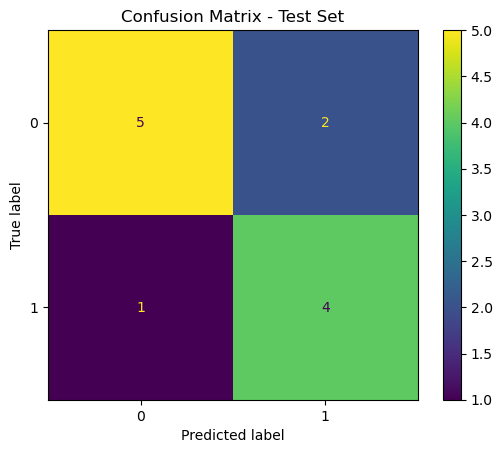

In [94]:
# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix - Test Set")
plt.show()

## 6) Visualize the predicted probability surface

To **interpolate/extrapolate** over EV/LA space:

1. Build a grid of (EV, LA) values that spans the observed data
2. Use the model to predict **P(hit)** at each grid point
3. Plot the surface as filled contours
4. Overlay the actual batted balls for visual context (hits vs outs)

The model will output probabilities even outside the observed range, so treat those regions cautiously.

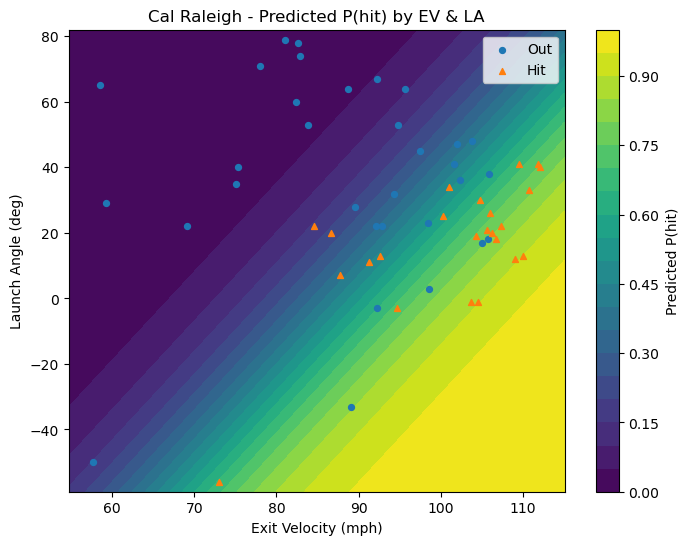

In [95]:
# define a grid over ev/la with a small margin
ev_min, ev_max = df["launch_speed"].min(), df["launch_speed"].max()
la_min, la_max = df["launch_angle"].min(), df["launch_angle"].max()

ev_pad = 3.0
la_pad = 3.0

ev_vals = np.linspace(ev_min - ev_pad, ev_max + ev_pad, 120)
la_vals = np.linspace(la_min - la_pad, la_max + la_pad, 120)

ev, la = np.meshgrid(ev_vals, la_vals)
grid = np.c_[ev.ravel(), la.ravel()]

proba = model.predict_proba(grid)[:, 1].reshape(ev.shape)

# plot the probability surface (one chart, default colors)
plt.figure(figsize=(8, 6))
contours = plt.contourf(ev, la, proba, levels=20)
plt.colorbar(contours, label="Predicted P(hit)")

# overlay actual points without specifying colors explicitly
hits = df[df["is_hit"] == 1]
outs = df[df["is_hit"] == 0]
plt.scatter(outs["launch_speed"], outs["launch_angle"], s=18, label="Out")
plt.scatter(hits["launch_speed"], hits["launch_angle"], s=18, label="Hit", marker="^")

plt.xlabel("Exit Velocity (mph)")
plt.ylabel("Launch Angle (deg)")
plt.title("Cal Raleigh - Predicted P(hit) by EV & LA")
plt.legend()
plt.show()


## 7) Predit P(hit) for any EV/LA pair

Use the helper function below to query the model for **any** EV/LA pair.

This supports both **interpolation** and **extrapolation**, so treat the extrapolated values cautiously

In [96]:
def predict_p_hit(ev_mph: float, la_deg: float) -> float:
  """ 
  return the model's predicted probability of a hit for a given ev/la.
  """
  X_new = np.array([[ev_mph, la_deg]], dtype=float)
  return float(model.predict_proba(X_new)[:, 1][0])

# example queries
examples = [(105, 25), (95, 20), (110, 40), (90, 1)]
for ev, la in examples:
  print(f"EV={ev} mph, LA={la} degrees -> P(hit) = {predict_p_hit(ev, la):.3f}")

EV=105 mph, LA=25 degrees -> P(hit) = 0.716
EV=95 mph, LA=20 degrees -> P(hit) = 0.457
EV=110 mph, LA=40 degrees -> P(hit) = 0.700
EV=90 mph, LA=1 degrees -> P(hit) = 0.525
